In [1]:
# KLUE-BERT Pairwise 문장 순서 예측 모델 (수정된 버전)

# 1. 필요한 라이브러리 import
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import itertools
from itertools import permutations
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import os
os.environ["WANDB_DISABLED"] = "true"

print("라이브러리 import 완료")

라이브러리 import 완료


In [2]:
# 환경 확인
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 디바이스: {torch.cuda.get_device_name(0)}")

PyTorch 버전: 2.6.0+cu124
CUDA 사용 가능: True
CUDA 디바이스: Tesla T4


In [3]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/sample_submission.csv')

In [5]:
# 실험용 데이터 크기 설정 (무료 GPU 실험용)
TRAIN_SAMPLE_SIZE = 2000  # 학습 데이터 제한
TEST_SAMPLE_SIZE = 1000   # 테스트 데이터 제한

# 데이터 제한
train = train.head(TRAIN_SAMPLE_SIZE).copy()
test = test.head(TEST_SAMPLE_SIZE).copy()
submission = submission.head(TEST_SAMPLE_SIZE).copy()

print("=== 데이터 로드 완료 ===")
print(f"Train 데이터: {len(train)} 샘플 (제한됨)")
print(f"Test 데이터: {len(test)} 샘플 (제한됨)")
print(f"Submission 형식: {submission.shape}")
print(f"⚠️ Train 데이터를 {TRAIN_SAMPLE_SIZE}개로 제한했습니다 (무료 GPU 실험용)")
print(f"⚠️ Test 데이터를 {TEST_SAMPLE_SIZE}개로 제한했습니다 (무료 GPU 실험용)")

=== 데이터 로드 완료 ===
Train 데이터: 2000 샘플 (제한됨)
Test 데이터: 1000 샘플 (제한됨)
Submission 형식: (1000, 5)
⚠️ Train 데이터를 2000개로 제한했습니다 (무료 GPU 실험용)
⚠️ Test 데이터를 1000개로 제한했습니다 (무료 GPU 실험용)


In [6]:
# 데이터 기본 정보 확인
print("=== Train 데이터 정보 ===")
train.info()
print("\n=== Test 데이터 정보 ===")
test.info()
print("\n=== Submission 형식 ===")
submission.info()

=== Train 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2000 non-null   object
 1   sentence_0  2000 non-null   object
 2   sentence_1  2000 non-null   object
 3   sentence_2  2000 non-null   object
 4   sentence_3  2000 non-null   object
 5   answer_0    2000 non-null   int64 
 6   answer_1    2000 non-null   int64 
 7   answer_2    2000 non-null   int64 
 8   answer_3    2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

=== Test 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1000 non-null   object
 1   sentence_0  1000 non-null   object
 2   sentence_1  1000 non-null   object
 3   sentence_2  1000 non-null   object
 4   sentence_3

In [7]:
# 텍스트 정제 함수
def clean_text(text):
    # 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 소문자 변환: 한글에는 무의미
    text = text.lower()
    # 불필요한 공백 제거
    text = ' '.join(text.split())
    return text

In [8]:
# 텍스트 정제 적용
for i in range(4):
    train[f'sentence_{i}'] = train[f'sentence_{i}'].apply(clean_text)
    test[f'sentence_{i}'] = test[f'sentence_{i}'].apply(clean_text)

print("텍스트 정제 완료")
print(f"정제 전후 비교:")
print(f"정제 전: {train['sentence_0'].iloc[0]}")
print(f"정제 후: {train['sentence_0'].iloc[0]}")

텍스트 정제 완료
정제 전후 비교:
정제 전: 블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다
정제 후: 블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다


In [9]:
## ✅ Pairwise 전처리 함수
def preprocess_pairwise(df):
    """
    문장들을 pairwise 형태로 변환
    각 문장 쌍에 대해 올바른 순서인지 여부를 레이블링
    """
    data = []
    for _, row in df.iterrows():
        sentences = [row[f'sentence_{i}'] for i in range(4)]
        answer = [row[f'answer_{i}'] for i in range(4)]

        # 올바른 순서로 정렬된 문장들
        ordered = [sentences[i] for i in answer]

        # 올바른 순서의 쌍들 (연속된 3개 쌍)
        positive_pairs = [(ordered[i], ordered[i+1]) for i in range(3)]

        # 모든 가능한 쌍들 (6개)
        all_pairs = list(itertools.permutations(sentences, 2))

        # 각 쌍에 대해 레이블링
        for s1, s2 in all_pairs:
            label = 1 if (s1, s2) in positive_pairs else 0
            data.append({'sentence1': s1, 'sentence2': s2, 'label': label})

    return pd.DataFrame(data)

In [10]:
# Pairwise 데이터 생성
pairwise_df = preprocess_pairwise(train)

print("=== Pairwise 데이터 정보 ===")
pairwise_df.info()
print(f"총 pairwise 샘플 수: {len(pairwise_df)}")
print(f"원본 train 샘플 수: {len(train)}")
print(f"pairwise 변환 비율: {len(pairwise_df)/len(train):.1f}배 (각 원본 샘플당 6개 쌍)")

# 클래스 불균형 확인
num_zeros = pairwise_df['label'].value_counts()[0]
num_ones = pairwise_df['label'].value_counts()[1]
print(f"\n클래스 0 (잘못된 순서): {num_zeros}개")
print(f"클래스 1 (올바른 순서): {num_ones}개")
print(f"불균형 비율: {num_zeros/num_ones:.2f}:1")

# 클래스 불균형 해결을 위한 가중치 계산
total = num_zeros + num_ones
weight_for_0 = total / (2 * num_zeros)
weight_for_1 = total / (2 * num_ones)

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float)
print("=== 클래스 가중치 ===")
print(f"클래스 0 가중치: {weight_for_0:.4f}")
print(f"클래스 1 가중치: {weight_for_1:.4f}")
print(f"가중치 비율: {weight_for_1/weight_for_0:.2f}:1")


=== Pairwise 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence1  24000 non-null  object
 1   sentence2  24000 non-null  object
 2   label      24000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 562.6+ KB
총 pairwise 샘플 수: 24000
원본 train 샘플 수: 2000
pairwise 변환 비율: 12.0배 (각 원본 샘플당 6개 쌍)

클래스 0 (잘못된 순서): 18000개
클래스 1 (올바른 순서): 6000개
불균형 비율: 3.00:1
=== 클래스 가중치 ===
클래스 0 가중치: 0.6667
클래스 1 가중치: 2.0000
가중치 비율: 3.00:1


In [11]:
# 2. 데이터셋 구성
MAX_TOKEN_LENGTH = 128

# 데이터셋 클래스 정의
class SentencePairDataset(Dataset):
    """
    문장 쌍을 받아 BERT 입력 형식으로 변환하는 PyTorch Dataset 클래스
    """
    def __init__(self, dataframe, tokenizer, max_length=MAX_TOKEN_LENGTH):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['sentence1'],
            row['sentence2'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

        if 'token_type_ids' in encoding:
            item['token_type_ids'] = encoding['token_type_ids'][0]

        return item

In [12]:
# 3. 모델 아키텍처 (KLUE-BERT)
class SentencePairModel(nn.Module):
    def __init__(self, model_name, num_labels=2, class_weights=None):
        super(SentencePairModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        # 클래스 가중치 적용
        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        # 마지막 4개 hidden layer 평균 (성능 향상)
        hidden_states = outputs.hidden_states
        last_four = torch.stack(hidden_states[-4:])
        avg_hidden = torch.mean(last_four, dim=0)
        cls_output = avg_hidden[:, 0]

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}


In [13]:
# 4. 학습 설정
# KLUE-BERT 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# 데이터 분할: 학습/검증 (8:2)
train_df, val_df = train_test_split(
    pairwise_df,
    test_size=0.2,
    stratify=pairwise_df['label'],
    random_state=42
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
# dataset 생성
train_dataset = SentencePairDataset(train_df, tokenizer, max_length=MAX_TOKEN_LENGTH)
val_dataset = SentencePairDataset(val_df, tokenizer, max_length=MAX_TOKEN_LENGTH)

print(f"Train 데이터: {len(train_dataset)} 샘플")
print(f"Validation 데이터: {len(val_dataset)} 샘플")
print(f"Train 클래스 분포: {train_df['label'].value_counts().to_dict()}")
print(f"Val 클래스 분포: {val_df['label'].value_counts().to_dict()}")

Train 데이터: 19200 샘플
Validation 데이터: 4800 샘플
Train 클래스 분포: {0: 14400, 1: 4800}
Val 클래스 분포: {0: 3600, 1: 1200}


In [15]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [16]:
# 클래스 가중치를 디바이스로 이동
class_weights = class_weights.to(device)

# KLUE-BERT 모델 인스턴스 생성
model = SentencePairModel("klue/bert-base", class_weights=class_weights).to(device)

# 샘플 데이터로 테스트
sample = train_dataset[0]
print("\n=== 샘플 데이터 확인 ===")
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention Mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels']}")

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


=== 샘플 데이터 확인 ===
Input IDs shape: torch.Size([128])
Attention Mask shape: torch.Size([128])
Label: 0


In [17]:
# 개선된 평가 지표 함수
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1)

    # 기본 지표
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, zero_division=0)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)

    # ROC-AUC (positive class 확률 사용)
    try:
        auc = roc_auc_score(labels, probs[:, 1])
    except:
        auc = 0.0

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

In [18]:
# 문장 순서 예측을 위한 추가 평가 지표들
def compute_order_metrics(predictions, labels, original_data):
    """
    문장 순서 예측을 위한 다양한 평가 지표 계산

    Args:
        predictions: 모델 예측 결과 (pairwise)
        labels: 실제 레이블 (pairwise)
        original_data: 원본 데이터 (4개 문장씩)
    """
    metrics = {}

    # 1. Sentence Accuracy (각 문장 쌍의 정확도)
    sentence_accuracy = accuracy_score(labels, predictions)
    metrics['sentence_accuracy'] = sentence_accuracy

    # 2. Full Order Accuracy (전체 순서가 정확한 비율)
    # 원본 데이터를 4개씩 그룹화하여 전체 순서 정확도 계산
    full_order_correct = 0
    total_groups = len(original_data) // 6  # 6개 쌍씩 그룹화

    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        # 4개 문장의 순서를 복원
        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)

        if np.array_equal(pred_order, true_order):
            full_order_correct += 1

    full_order_accuracy = full_order_correct / total_groups
    metrics['full_order_accuracy'] = full_order_accuracy

    # 3. Kendall's Tau (순서 상관관계)
    kendall_taus = []
    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)

        tau = calculate_kendall_tau(pred_order, true_order)
        kendall_taus.append(tau)

    avg_kendall_tau = np.mean(kendall_taus)
    metrics['kendall_tau'] = avg_kendall_tau

    # 4. Spearman's Rho (순위 상관관계)
    spearman_rhos = []
    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)

        rho = calculate_spearman_rho(pred_order, true_order)
        spearman_rhos.append(rho)

    avg_spearman_rho = np.mean(spearman_rhos)
    metrics['spearman_rho'] = avg_spearman_rho

    # 5. Position-wise Accuracy (각 위치별 정확도)
    position_accuracies = []
    for pos in range(4):
        correct_pos = 0
        total_pos = 0

        for i in range(total_groups):
            start_idx = i * 6
            end_idx = start_idx + 6

            group_preds = predictions[start_idx:end_idx]
            group_labels = labels[start_idx:end_idx]

            pred_order = reconstruct_order_from_pairs(group_preds)
            true_order = reconstruct_order_from_pairs(group_labels)

            if pred_order[pos] == true_order[pos]:
                correct_pos += 1
            total_pos += 1

        pos_accuracy = correct_pos / total_pos
        position_accuracies.append(pos_accuracy)

    metrics['position_accuracy'] = position_accuracies

    # 6. Adjacent Pair Accuracy (인접 쌍 정확도)
    adjacent_correct = 0
    total_adjacent = 0

    for i in range(0, len(predictions), 6):
        group_preds = predictions[i:i+6]
        group_labels = labels[i:i+6]

        # 인접 쌍만 추출 (0-1, 1-2, 2-3)
        adjacent_preds = [group_preds[0], group_preds[2], group_preds[4]]  # 인덱스 확인 필요
        adjacent_labels = [group_labels[0], group_labels[2], group_labels[4]]

        for pred, label in zip(adjacent_preds, adjacent_labels):
            if pred == label:
                adjacent_correct += 1
            total_adjacent += 1

    adjacent_accuracy = adjacent_correct / total_adjacent
    metrics['adjacent_pair_accuracy'] = adjacent_accuracy

    # 7. Long-range Pair Accuracy (원거리 쌍 정확도)
    long_range_correct = 0
    total_long_range = 0

    for i in range(0, len(predictions), 6):
        group_preds = predictions[i:i+6]
        group_labels = labels[i:i+6]

        # 원거리 쌍 추출 (0-2, 0-3, 1-3)
        long_range_preds = [group_preds[1], group_preds[3], group_preds[5]]  # 인덱스 확인 필요
        long_range_labels = [group_labels[1], group_labels[3], group_labels[5]]

        for pred, label in zip(long_range_preds, long_range_labels):
            if pred == label:
                long_range_correct += 1
            total_long_range += 1

    long_range_accuracy = long_range_correct / total_long_range
    metrics['long_range_pair_accuracy'] = long_range_accuracy

    return metrics


In [19]:
def reconstruct_order_from_pairs(pair_predictions):
    """
    pairwise 예측 결과로부터 전체 순서를 복원
    """
    # 6개 쌍의 예측을 4개 문장의 순서로 변환
    # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3) 순서로 가정
    scores = np.zeros(4)

    # 각 문장의 점수 계산
    # (0,1): 0이 1보다 앞에 있으면 0에 +1, 1에 -1
    if pair_predictions[0] == 1:  # 0이 1보다 앞
        scores[0] += 1
        scores[1] -= 1
    else:  # 1이 0보다 앞
        scores[1] += 1
        scores[0] -= 1

    if pair_predictions[1] == 1:  # 0이 2보다 앞
        scores[0] += 1
        scores[2] -= 1
    else:
        scores[2] += 1
        scores[0] -= 1

    if pair_predictions[2] == 1:  # 0이 3보다 앞
        scores[0] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[0] -= 1

    if pair_predictions[3] == 1:  # 1이 2보다 앞
        scores[1] += 1
        scores[2] -= 1
    else:
        scores[2] += 1
        scores[1] -= 1

    if pair_predictions[4] == 1:  # 1이 3보다 앞
        scores[1] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[1] -= 1

    if pair_predictions[5] == 1:  # 2가 3보다 앞
        scores[2] += 1
        scores[3] -= 1
    else:
        scores[3] += 1
        scores[2] -= 1

    # 점수 기반으로 순서 결정
    return np.argsort(scores)[::-1].tolist()  # 리스트로 변환하여 반환


In [20]:
def calculate_kendall_tau(pred_order, true_order):
    """
    Kendall's Tau 계산
    """
    # 리스트를 numpy 배열로 변환
    pred_order = np.array(pred_order)
    true_order = np.array(true_order)

    n = len(pred_order)
    concordant = 0
    discordant = 0

    for i in range(n):
        for j in range(i+1, n):
            pred_diff = pred_order[i] - pred_order[j]
            true_diff = true_order[i] - true_order[j]

            if (pred_diff * true_diff) > 0:
                concordant += 1
            elif (pred_diff * true_diff) < 0:
                discordant += 1

    if concordant + discordant == 0:
        return 0.0

    tau = (concordant - discordant) / (concordant + discordant)
    return tau

In [21]:
def calculate_spearman_rho(pred_order, true_order):
    """
    Spearman's Rho 계산
    """
    from scipy.stats import spearmanr
    try:
        # 리스트를 numpy 배열로 변환
        pred_order = np.array(pred_order)
        true_order = np.array(true_order)

        rho, _ = spearmanr(pred_order, true_order)
        return rho if not np.isnan(rho) else 0.0
    except:
        return 0.0

In [22]:
# 학습 인자 설정 (무료 GPU 실험용 - 빠른 테스트)
training_args = TrainingArguments(
    output_dir='./klue_bert_results_test',
    num_train_epochs=3,  # 에포크 수 감소
    per_device_train_batch_size=8,  # 배치 크기 감소
    per_device_eval_batch_size=32,  # 평가 배치 크기 감소
    warmup_steps=100,  # 워밍업 스텝 감소
    weight_decay=0.01,
    logging_dir='./klue_bert_logs_test',
    logging_steps=50,  # 로깅 빈도 증가
    save_strategy='epoch',
    eval_strategy='epoch',
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to='none'
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [23]:
# 학습 실행
print("KLUE-BERT 모델 학습 시작...")
trainer.train()

KLUE-BERT 모델 학습 시작...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.440300,0.490415,0.830833,0.651203,0.671986,0.631667,0.895138
2,0.387800,0.473252,0.872708,0.752130,0.732806,0.772500,0.937543
3,0.260500,0.740017,0.893542,0.776368,0.817512,0.739167,0.948623


TrainOutput(global_step=7200, training_loss=0.34735903633965387, metrics={'train_runtime': 1613.8895, 'train_samples_per_second': 35.69, 'train_steps_per_second': 4.461, 'total_flos': 0.0, 'train_loss': 0.34735903633965387, 'epoch': 3.0})

In [24]:
# 최종 평가
eval_results = trainer.evaluate()
print("=== 최종 Validation 결과 ===")
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")

=== 최종 Validation 결과 ===
eval_loss: 0.7400
eval_accuracy: 0.8935
eval_f1: 0.7764
eval_precision: 0.8175
eval_recall: 0.7392
eval_auc: 0.9486
eval_runtime: 33.0820
eval_samples_per_second: 145.0940
eval_steps_per_second: 4.5340


In [25]:
# 5. 결과 분석 및 시각화
# 예측 결과 분석
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)

# 문장 순서 예측을 위한 추가 평가 지표 계산
print("=== 문장 순서 예측 평가 지표 ===")
order_metrics = compute_order_metrics(preds, labels, val_df)

print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== Position-wise Accuracy ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

=== 문장 순서 예측 평가 지표 ===
Sentence Accuracy: 0.8935
Full Order Accuracy: 0.6162
Kendall's Tau: 0.7508
Spearman's Rho: 0.7895
Adjacent Pair Accuracy: 0.8912
Long-range Pair Accuracy: 0.8958

=== Position-wise Accuracy ===
Position 0: 0.8250
Position 1: 0.7013
Position 2: 0.7000
Position 3: 0.8350


(0.0, 1.0)

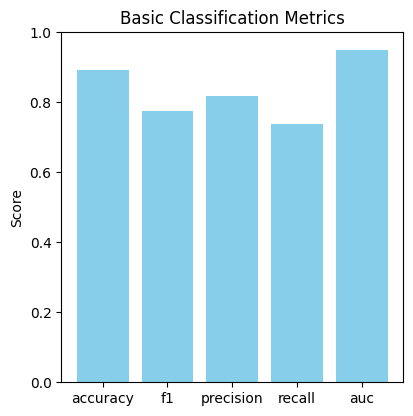

In [26]:
# 평가 지표 시각화
plt.figure(figsize=(15, 10))

# 1. 기본 분류 지표
plt.subplot(2, 3, 1)
basic_metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
basic_values = [eval_results[f'eval_{m}'] for m in basic_metrics]
plt.bar(basic_metrics, basic_values, color='skyblue')
plt.title('Basic Classification Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

(-1.0, 1.0)

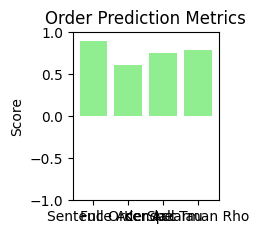

In [27]:
# 2. 순서 예측 지표
plt.subplot(2, 3, 2)
order_metric_names = ['Sentence Acc', 'Full Order Acc', 'Kendall Tau', 'Spearman Rho']
order_metric_values = [
    order_metrics['sentence_accuracy'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau'],
    order_metrics['spearman_rho']
]
plt.bar(order_metric_names, order_metric_values, color='lightgreen')
plt.title('Order Prediction Metrics')
plt.ylabel('Score')
plt.ylim(-1, 1)

(0.0, 1.0)

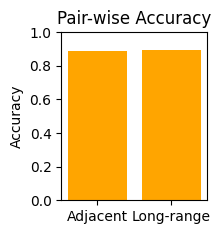

In [28]:
# 3. 쌍별 정확도
plt.subplot(2, 3, 3)
pair_metrics = ['Adjacent', 'Long-range']
pair_values = [
    order_metrics['adjacent_pair_accuracy'],
    order_metrics['long_range_pair_accuracy']
]
plt.bar(pair_metrics, pair_values, color='orange')
plt.title('Pair-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

(0.0, 1.0)

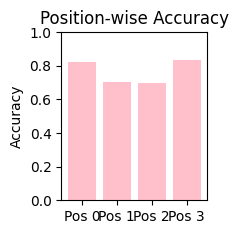

In [29]:
# 4. 위치별 정확도
plt.subplot(2, 3, 4)
positions = ['Pos 0', 'Pos 1', 'Pos 2', 'Pos 3']
pos_values = order_metrics['position_accuracy']
plt.bar(positions, pos_values, color='pink')
plt.title('Position-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

Text(0, 0.5, 'Frequency')

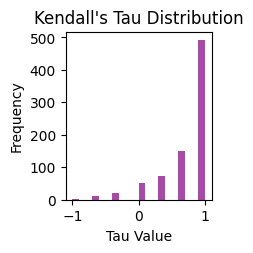

In [30]:
# 5. Kendall's Tau 분포
plt.subplot(2, 3, 5)
# 실제 tau 값들을 계산하여 분포 시각화
tau_values = []
for i in range(0, len(preds), 6):
    if i + 6 <= len(preds):
        group_preds = preds[i:i+6]
        group_labels = labels[i:i+6]
        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)
        tau = calculate_kendall_tau(pred_order, true_order)
        tau_values.append(tau)

plt.hist(tau_values, bins=20, alpha=0.7, color='purple')
plt.title('Kendall\'s Tau Distribution')
plt.xlabel('Tau Value')
plt.ylabel('Frequency')

## 전체 성능 요약

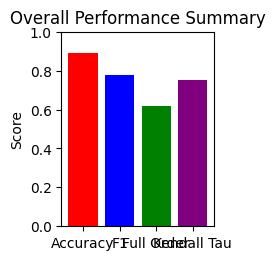

In [31]:
# 6. 전체 성능 요약
plt.subplot(2, 3, 6)
summary_metrics = ['Accuracy', 'F1', 'Full Order', 'Kendall Tau']
summary_values = [
    eval_results['eval_accuracy'],
    eval_results['eval_f1'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau']
]
colors = ['red', 'blue', 'green', 'purple']
plt.bar(summary_metrics, summary_values, color=colors)
plt.title('Overall Performance Summary')
plt.ylabel('Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

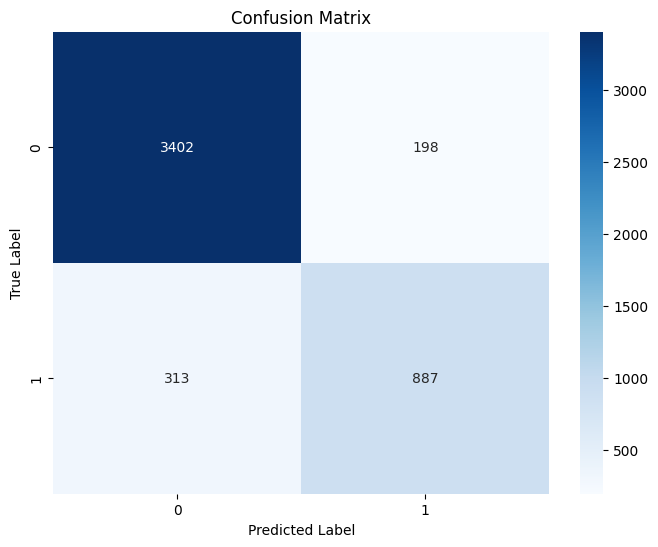

In [32]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3600
           1       0.82      0.74      0.78      1200

    accuracy                           0.89      4800
   macro avg       0.87      0.84      0.85      4800
weighted avg       0.89      0.89      0.89      4800



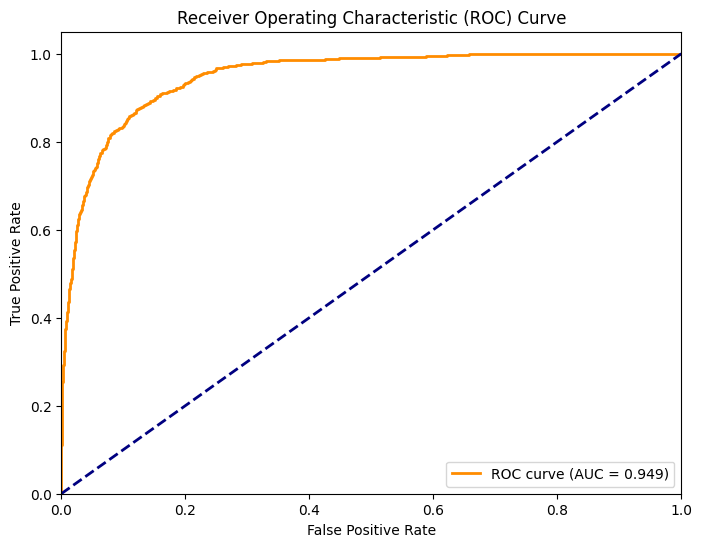

In [33]:
# Classification Report
print("\n=== Classification Report ===")
print(classification_report(labels, preds))

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs[:, 1])
auc_score = roc_auc_score(labels, probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

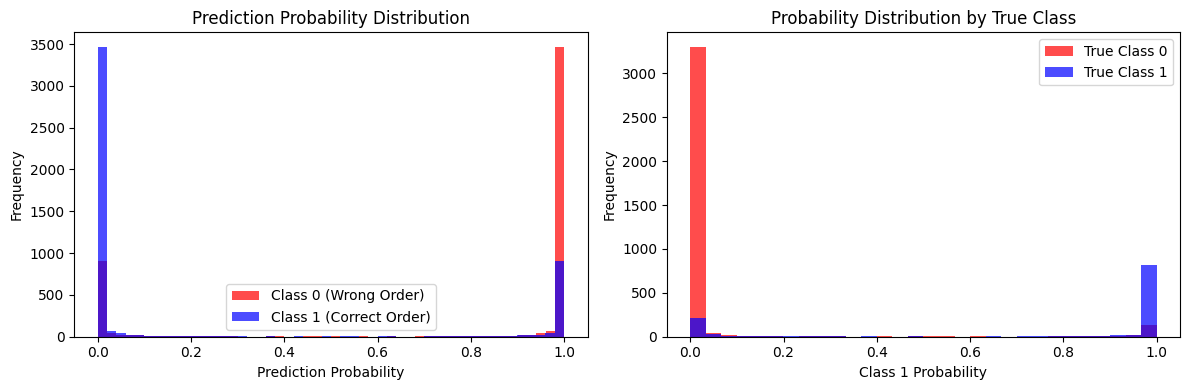

In [34]:
# 클래스별 예측 분포 분석
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(probs[:, 0], bins=50, alpha=0.7, label='Class 0 (Wrong Order)', color='red')
plt.hist(probs[:, 1], bins=50, alpha=0.7, label='Class 1 (Correct Order)', color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.subplot(1, 2, 2)
class_0_probs = probs[labels == 0, 1]
class_1_probs = probs[labels == 1, 1]
plt.hist(class_0_probs, bins=30, alpha=0.7, label='True Class 0', color='red')
plt.hist(class_1_probs, bins=30, alpha=0.7, label='True Class 1', color='blue')
plt.xlabel('Class 1 Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# 6. 추론 및 예측
# 개선된 예측 함수
def predict_order(sent1, sent2, model, tokenizer, device='cpu'):
    model.eval()
    inputs = tokenizer(
        sent1,
        sent2,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_TOKEN_LENGTH
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs['logits'], dim=1)

    return predictions, predictions.argmax().item()

In [36]:
# 페어와이즈 점수 계산 함수
def pair_score(s1, s2):
    probs, _ = predict_order(s1, s2, model, tokenizer, device)
    return probs[0][1].item()  # label=1 확률

In [37]:
# 효율적인 순열 탐색 (Greedy 알고리즘)
def find_best_order_greedy(sentences):
    """Greedy 알고리즘으로 최적 순서 찾기"""
    n = len(sentences)
    if n <= 1:
        return list(range(n))

    # 첫 번째 문장 선택 (가장 높은 점수를 받는 문장)
    best_first = 0
    best_score = -1

    for i in range(n):
        total_score = 0
        for j in range(n):
            if i != j:
                total_score += pair_score(sentences[i], sentences[j])
        if total_score > best_score:
            best_score = total_score
            best_first = i

    # 나머지 문장들을 순차적으로 배치
    remaining = list(range(n))
    remaining.remove(best_first)

    result = [best_first]
    current = best_first

    while remaining:
        best_next = remaining[0]
        best_score = pair_score(sentences[current], sentences[remaining[0]])

        for next_idx in remaining[1:]:
            score = pair_score(sentences[current], sentences[next_idx])
            if score > best_score:
                best_score = score
                best_next = next_idx

        result.append(best_next)
        remaining.remove(best_next)
        current = best_next

    return result


In [38]:
# 테스트 데이터 예측 (제한된 데이터)
pred_orders = []
pred_scores = []

print(f"테스트 데이터 예측 시작... ({len(test)}개 샘플)")
for idx, (_, row) in enumerate(tqdm(test.iterrows(), total=len(test), desc="문장 순서 예측")):
    sents = [row[f'sentence_{i}'] for i in range(4)]

    # Greedy 알고리즘 사용
    best_perm = find_best_order_greedy(sents)

    # 점수 계산
    score = sum(pair_score(sents[best_perm[i]], sents[best_perm[i+1]]) for i in range(3))

    pred_orders.append(best_perm)
    pred_scores.append(score)

    # 진행상황 출력 (더 자주)
    if (idx + 1) % 50 == 0:
        print(f"[{idx+1}/{len(test)}] 완료, 현재 평균 점수: {np.mean(pred_scores):.4f}")

테스트 데이터 예측 시작... (1000개 샘플)


문장 순서 예측:   0%|          | 0/1000 [00:00<?, ?it/s]

[50/1000] 완료, 현재 평균 점수: 1.8667
[100/1000] 완료, 현재 평균 점수: 1.8757
[150/1000] 완료, 현재 평균 점수: 1.8311
[200/1000] 완료, 현재 평균 점수: 1.8446
[250/1000] 완료, 현재 평균 점수: 1.8658
[300/1000] 완료, 현재 평균 점수: 1.8869
[350/1000] 완료, 현재 평균 점수: 1.8828
[400/1000] 완료, 현재 평균 점수: 1.8810
[450/1000] 완료, 현재 평균 점수: 1.8696
[500/1000] 완료, 현재 평균 점수: 1.8681
[550/1000] 완료, 현재 평균 점수: 1.8617
[600/1000] 완료, 현재 평균 점수: 1.8418
[650/1000] 완료, 현재 평균 점수: 1.8328
[700/1000] 완료, 현재 평균 점수: 1.8225
[750/1000] 완료, 현재 평균 점수: 1.8188
[800/1000] 완료, 현재 평균 점수: 1.8156
[850/1000] 완료, 현재 평균 점수: 1.8250
[900/1000] 완료, 현재 평균 점수: 1.8274
[950/1000] 완료, 현재 평균 점수: 1.8253
[1000/1000] 완료, 현재 평균 점수: 1.8106


In [39]:
# Submission 파일 생성
for idx, perm in enumerate(pred_orders):
    for i, p in enumerate(perm):
        submission.loc[idx, f'answer_{i}'] = p

submission.to_csv('klue_bert_results_test/submission_test.csv', index=False)
print("✅ submission_test.csv 파일이 생성되었습니다.")
print(f"예측된 순서의 평균 점수: {np.mean(pred_scores):.4f}")
print(f"예측된 순서 샘플: {pred_orders[:5]}")

✅ submission_test.csv 파일이 생성되었습니다.
예측된 순서의 평균 점수: 1.8106
예측된 순서 샘플: [[1, 2, 3, 0], [0, 3, 1, 2], [0, 3, 2, 1], [3, 2, 0, 1], [0, 1, 2, 3]]


## 추가 분석 및 인사이트

In [40]:
# 7. 추가 분석 및 인사이트
# 예측 결과 분석
print("=== 예측 결과 분석 ===")
print(f"평균 예측 점수: {np.mean(pred_scores):.4f}")
print(f"최고 예측 점수: {np.max(pred_scores):.4f}")
print(f"최저 예측 점수: {np.min(pred_scores):.4f}")
print(f"예측 점수 표준편차: {np.std(pred_scores):.4f}")

=== 예측 결과 분석 ===
평균 예측 점수: 1.8106
최고 예측 점수: 2.9993
최저 예측 점수: 0.0098
예측 점수 표준편차: 0.7032


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

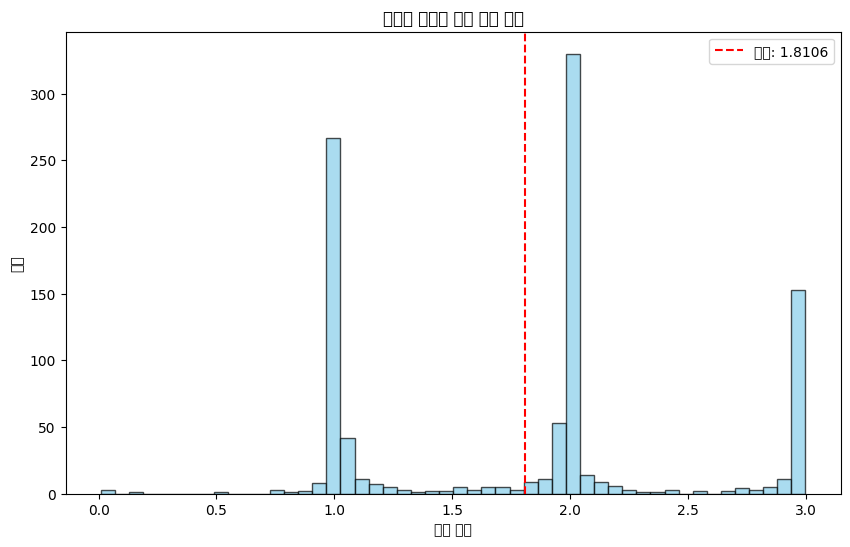

In [41]:
# 점수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(pred_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(pred_scores), color='red', linestyle='--', label=f'평균: {np.mean(pred_scores):.4f}')
plt.xlabel('예측 점수')
plt.ylabel('빈도')
plt.title('테스트 데이터 예측 점수 분포')
plt.legend()
plt.show()

In [42]:
# 모델 성능 요약
print("=== KLUE-BERT 모델 성능 요약 ===")
print("=== 기본 분류 지표 ===")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Validation Precision: {eval_results['eval_precision']:.4f}")
print(f"Validation Recall: {eval_results['eval_recall']:.4f}")
print(f"Validation AUC: {eval_results['eval_auc']:.4f}")

print("\n=== 문장 순서 예측 지표 ===")
print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== 위치별 정확도 ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

print(f"\n테스트 예측 평균 점수: {np.mean(pred_scores):.4f}")

=== KLUE-BERT 모델 성능 요약 ===
=== 기본 분류 지표 ===
Validation Accuracy: 0.8935
Validation F1 Score: 0.7764
Validation Precision: 0.8175
Validation Recall: 0.7392
Validation AUC: 0.9486

=== 문장 순서 예측 지표 ===
Sentence Accuracy: 0.8935
Full Order Accuracy: 0.6162
Kendall's Tau: 0.7508
Spearman's Rho: 0.7895
Adjacent Pair Accuracy: 0.8912
Long-range Pair Accuracy: 0.8958

=== 위치별 정확도 ===
Position 0: 0.8250
Position 1: 0.7013
Position 2: 0.7000
Position 3: 0.8350

테스트 예측 평균 점수: 1.8106


In [43]:
# 예측 순서의 다양성 분석
unique_orders = set()
for pred in pred_orders:
    unique_orders.add(tuple(pred))

print(f"\n고유한 예측 순서 수: {len(unique_orders)}")
print(f"예측 다양성 비율: {len(unique_orders)/len(pred_orders)*100:.2f}%")


고유한 예측 순서 수: 24
예측 다양성 비율: 2.40%


In [44]:
# 파일 다운로드
from google.colab import files
files.download('klue_bert_results_test/submission_test.csv')

print("✅ submission_test.csv 파일이 다운로드되었습니다.")
print("\n=== 최종 결과 ===")
print(f"모델: KLUE-BERT")
print(f"방식: Pairwise")
print(f"Validation F1: {eval_results['eval_f1']:.4f}")
print(f"테스트 예측 완료: {len(pred_orders)} 샘플")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ submission_test.csv 파일이 다운로드되었습니다.

=== 최종 결과 ===
모델: KLUE-BERT
방식: Pairwise
Validation F1: 0.7764
테스트 예측 완료: 1000 샘플
